In [1]:
from sympy import *
import matplotlib.pyplot as plt

init_printing()

In [30]:
c = [Matrix((x,)) for x in [(-1, 1), ( 0, 1), ( 1, 1), (-1, 0), ( 0, 0), ( 1, 0), (-1,-1), ( 0, -1), ( 1, -1)]]

In [31]:
c

[[-1  1], [0  1], [1  1], [-1  0], [0  0], [1  0], [-1  -1], [0  -1], [1  -1]]

In [32]:
w = [Rational(*x) for x in [(1,36), (1,9), (1,36), (1,9), (4,9), (1,9), (1,36), (1,9), (1,36)]]

In [33]:
w

In [34]:
sum(w)

In [35]:
c_s = sqrt(Rational(1,3))
c_s

In [36]:
u_x, u_y, rho, tau = symbols('u_x u_y rho tau')

In [37]:
f_next = symarray('f_next', 9)
f_next

array([f_next_0, f_next_1, f_next_2, f_next_3, f_next_4, f_next_5,
       f_next_6, f_next_7, f_next_8], dtype=object)

In [38]:
f_curr = symarray('f_curr', 9)
f_curr

array([f_curr_0, f_curr_1, f_curr_2, f_curr_3, f_curr_4, f_curr_5,
       f_curr_6, f_curr_7, f_curr_8], dtype=object)

In [39]:
rho = sum(f_curr)
rho

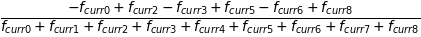

In [40]:
u_x = sum([ (c_i*f_curr[i])[0] for i, c_i in enumerate(c) ]) / rho
u_x

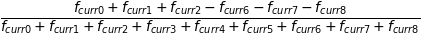

In [41]:
u_y = sum([ (c_i*f_curr[i])[1] for i, c_i in enumerate(c) ]) / rho
u_y

In [42]:
u = Matrix([u_x, u_y])
u

⎡                -f_curr_0 + f_curr_2 - f_curr_3 + f_curr_5 - f_curr_6 + f_cur
⎢─────────────────────────────────────────────────────────────────────────────
⎢f_curr_0 + f_curr_1 + f_curr_2 + f_curr_3 + f_curr_4 + f_curr_5 + f_curr_6 + 
⎢                                                                             
⎢                f_curr_0 + f_curr_1 + f_curr_2 - f_curr_6 - f_curr_7 - f_curr
⎢─────────────────────────────────────────────────────────────────────────────
⎣f_curr_0 + f_curr_1 + f_curr_2 + f_curr_3 + f_curr_4 + f_curr_5 + f_curr_6 + 

r_8                ⎤
───────────────────⎥
f_curr_7 + f_curr_8⎥
                   ⎥
_8                 ⎥
───────────────────⎥
f_curr_7 + f_curr_8⎦

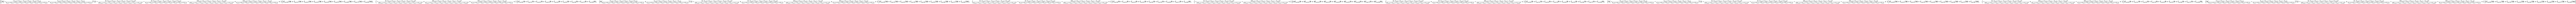

In [43]:
f_eq = []

for i, c_i in enumerate(c):
    f_eq_i = w[i] * rho * (  1
                           + c_i.dot(u)    /    c_s**2
                           + c_i.dot(u)**2 / (2*c_s**4)
                           - u.dot(u)      / (2*c_s**2) )
    f_eq.append(f_eq_i)

f_eq

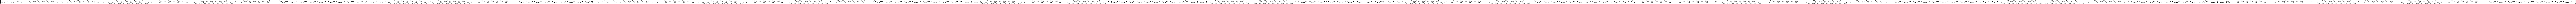

In [44]:
f_next = [ f_curr[i] + 1/tau * ( f_eq_i - f_curr[i] ) for i, f_eq_i in enumerate(f_eq) ]
f_next

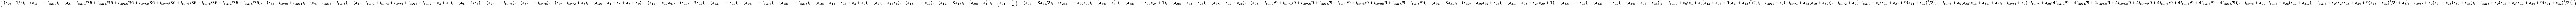

In [45]:
cse(f_next)

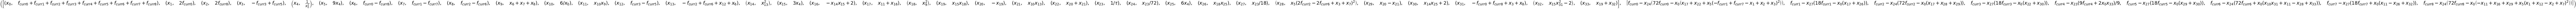

In [46]:
eqs = cse(f_next, optimizations='basic')
eqs

In [49]:
for eq in eqs[0]:
    print("const float %s = %s;" % (eq[0], ccode(eq[1])))

const float x0 = f_curr_0 + f_curr_1 + f_curr_2 + f_curr_3 + f_curr_4 + f_curr_5 + f_curr_6 + f_curr_7 + f_curr_8;
const float x1 = 2*f_curr_0;
const float x2 = 2*f_curr_8;
const float x3 = -f_curr_3 + f_curr_5;
const float x4 = pow(x0, -2);
const float x5 = 9*x4;
const float x6 = f_curr_0 - f_curr_8;
const float x7 = f_curr_1 - f_curr_7;
const float x8 = f_curr_2 - f_curr_6;
const float x9 = x6 + x7 + x8;
const float x10 = 6/x0;
const float x11 = x10*x9;
const float x12 = f_curr_3 - f_curr_5;
const float x13 = -f_curr_2 + f_curr_6 + x12 + x6;
const float x14 = pow(x13, 2);
const float x15 = 3*x4;
const float x16 = -x14*x15 + 2;
const float x17 = x11 + x16;
const float x18 = pow(x9, 2);
const float x19 = x15*x18;
const float x20 = -x19;
const float x21 = x10*x13;
const float x22 = x20 + x21;
const float x23 = 1.0/tau;
const float x24 = (1.0/72.0)*x23;
const float x25 = 6*x4;
const float x26 = x18*x25;
const float x27 = (1.0/18.0)*x23;
const float x28 = x5*pow(2*f_curr_2 - 2*f_curr_6 + 

In [53]:
for i, eq in enumerate(eqs[1]):
    print("f_next_%d = %s;" % (i, ccode(eq)))

f_next_0 = f_curr_0 - x24*(72*f_curr_0 - x0*(x17 + x22 + x5*pow(-f_curr_1 + f_curr_7 - x1 + x2 + x3, 2)));
f_next_1 = f_curr_1 - x27*(18*f_curr_1 - x0*(x17 + x26));
f_next_2 = f_curr_2 - x24*(72*f_curr_2 - x0*(x17 + x28 + x29));
f_next_3 = f_curr_3 - x27*(18*f_curr_3 - x0*(x22 + x30));
f_next_4 = f_curr_4 - 1.0/9.0*x23*(9*f_curr_4 + 2*x0*x33);
f_next_5 = f_curr_5 - x27*(18*f_curr_5 - x0*(x29 + x30));
f_next_6 = f_curr_6 - x24*(72*f_curr_6 + x0*(x10*x31 + x11 - x28 + x33));
f_next_7 = f_curr_7 - x27*(18*f_curr_7 + x0*(x11 - x26 + x32));
f_next_8 = f_curr_8 - x24*(72*f_curr_8 - x0*(-x11 + x16 + x29 + x5*pow(x1 + x12 - x2 + x7, 2)));
